Equivalent notebook to `calc_dailyvariance-of-sectormeans_globcolor.ipynb`, except first take monthly means. This is for more direct comparison to model output.

In [1]:
import xarray as xr
import numpy as np
import dask
import matplotlib.pyplot as plt
from utils import geo
import pandas as pd
import regionmask
from dask.diagnostics import ProgressBar
import glob
import os

In [2]:
dataset = 'globcolour-cmems'
frequency = 'day'
variable = 'CHL'
yearstart = 1998
yearend = 2023
monthorder = 'JANtoDEC'
averaging = 'wmean-latlon_climvar'

In [3]:
rootdir = '/projects/SOCCOM/datasets/GlobColour/'
local = 'CMEMS/OCEANCOLOUR_GLO_BGC_L4_MY_009_104-TDS/SouthernOcean_55Sto80S/'+frequency+'/bymonth/'
filename = 'cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_*.nc'

print('Opening.')
paths = glob.glob(rootdir+local+filename)
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = xr.open_mfdataset(paths,use_cftime=True)
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,axes_dims_dict={'X':'lon','Y':'lat'},periodic='X')
ds['area'] = ds['dxC']*ds['dyC']
ds = ds.chunk({'time':'auto'})

Opening.


In [4]:
ds = ds.resample(time="1MS").mean(dim='time')
ds = ds.chunk({'time':'auto'})

In [5]:
ds

<xarray.Dataset>
Dimensions:          (lat: 601, lon: 8640, lon_left: 8640, lat_left: 601,
                      time: 312)
Coordinates:
  * lat              (lat) float32 -54.98 -55.02 -55.06 ... -79.9 -79.94 -79.98
  * lon              (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * lon_left         (lon_left) float32 -180.0 -180.0 -179.9 ... 179.9 180.0
  * lat_left         (lat_left) float32 -54.96 -55.0 -55.04 ... -79.92 -79.96
  * time             (time) object 1997-09-01 00:00:00 ... 2023-08-01 00:00:00
Data variables:
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(6, 601, 8640), meta=np.ndarray>
    CHL              (time, lat, lon) float32 dask.array<chunksize=(6, 601, 8640), meta=np.ndarray>
    flags            (time, lat, lon) float64 dask.array<chunksize=(3, 601, 8640), meta=np.ndarray>
    dxG              (time, lon_left, lat) float32 dask.array<chunksize=(6, 8640, 601), meta=np.ndarray>
    dyG              (time, lon, lat_left) float32 dask.array<chunksize=(6, 8640, 601), meta=np.ndarray>
    dxC              (time, lon, lat) float32 dask.array<chunksize=(6, 8640, 601), meta=np.ndarray>
    dyC              (time, lon, lat) float32 dask.array<chunksize=(6, 8640, 601), meta=np.ndarray>
    rC               (time, lon, lat) float32 dask.array<chunksize=(6, 8640, 601), meta=np.ndarray>
    area             (time, lon, lat) float32 dask.array<chunksize=(6, 8640, 601), meta=np.ndarray>
Attributes: (12/92)
    lon_step:                        0.041666668
    keywords:                        EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    lat_step:                        0.041666668
    grid_mapping:                    Equirectangular
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    ...                              ...
    westernmost_longitude:           -180.0
    geospatial_vertical_positive:    up
    date_created:                    2023-08-28T01:41:45Z
    nb_valid_bins:                   20785524
    pct_valid_bins:                  55.68823945473251
    History:                         Translated to CF-1.0 Conventions by Netc...

In [6]:
# Apply a landmask
mask = regionmask.defined_regions.natural_earth.land_110.mask(ds['lon'], ds['lat'])
mask = mask.where(np.isfinite(mask),1)
mask = mask.where(mask==1,np.nan)
# mask.plot()
ds[variable] = ds[variable].fillna(0)*mask

/home/graemem/.conda/envs/core/lib/python3.10/site-packages/regionmask/defined_regions/_natural_earth.py:471: FutureWarning: ``regionmask.defined_regions.natural_earth`` is deprecated. Please use ``regionmask.defined_regions.natural_earth_v4_1_0`` or ``regionmask.defined_regions.natural_earth_v5_0_0`` instead.
  warnings.warn(


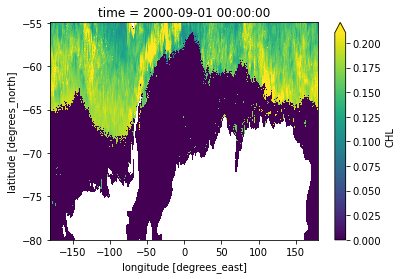

In [7]:
ds[variable].sel(time='2000-09-01').plot(robust=True)

### Variance (as a function of month) map

In [8]:
clim = ds['CHL'].groupby('time.month').mean()
var = ds['CHL'].groupby('time.month').var()

perc = var/clim

In [13]:
# Save to netcdf
outdir = '../../../data/'
averaging = 'percentagevariance'
yearstr = str(yearstart).zfill(4)+'-'+str(yearend).zfill(4)
outpath = outdir+'.'.join([dataset,frequency+'-tomonthly',averaging,monthorder,yearstr,'ForBuchovecky','nc'])
with ProgressBar():
    perc.to_netcdf(outpath)

[#######################                 ] | 57% Completed | 12m 11ss

/home/graemem/.conda/envs/core/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[#######################                 ] | 57% Completed | 12m 11s

/home/graemem/.conda/envs/core/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 20m 31s


### By sector

In [8]:
# Regional averages
bound_dicts = {
    'PanAntarctic':None,
    'Weddell':[-60,20],
    'Indian':[20,90],
    'WestPacific':[90,160],
    'Ross':[160,-130],
    'AB':[-130,-60]
}

dsmean = xr.Dataset(coords = {'time':ds['time']})

for sector,bounds in bound_dicts.items():
    print(sector)
    # Specify bounds
    if sector=='PanAntarctic':
        cond = xr.ones_like(ds['area'])
    elif bounds[0]>bounds[1]:
        cond = (ds['lon']>=bounds[0]) | (ds['lon']<bounds[1])
    else:
        cond = (ds['lon']>=bounds[0]) & (ds['lon']<bounds[1])
    # Apply sector mask
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        dssector = ds.where(cond,drop=True)
        
    dsmean[sector] = dssector[variable].weighted(dssector['area'].fillna(0)).mean(['lat','lon'])
# Rechunk
dsmean = dsmean.chunk({'time':'auto'})

PanAntarctic
Weddell
Indian
WestPacific
Ross
AB


In [9]:
# Group by day of year and compute variance
dsvar = dsmean.groupby('time.month').std()**2

In [ ]:
# Save to netcdf
outdir = '../../data/'
yearstr = str(yearstart)+'-'+str(yearend)
outpath = outdir+'.'.join([dataset,frequency+'-tomonthly',averaging,monthorder,yearstr,'ForBuchovecky','nc'])
with ProgressBar():
    dsvar.to_netcdf(outpath)

[##########                              ] | 27% Completed | 17m 55ss

In [ ]:
with ProgressBar():
    dsmean = dsmean.compute()

[                                        ] | 1% Completed | 94.55 sms

In [ ]:
dsmean['PanAntarctic'].plot()